# Morphing

Demonstrate combining multiple flow models with some analytical morphing weights. Use three basis Gaussians at different ($\mu, \sigma$) points. Morphing interpolates between them.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import nami

torch.manual_seed(42)

## Define basis distributions

Three 2D Gaussians at different locations/scales as our "simulated" basis points.

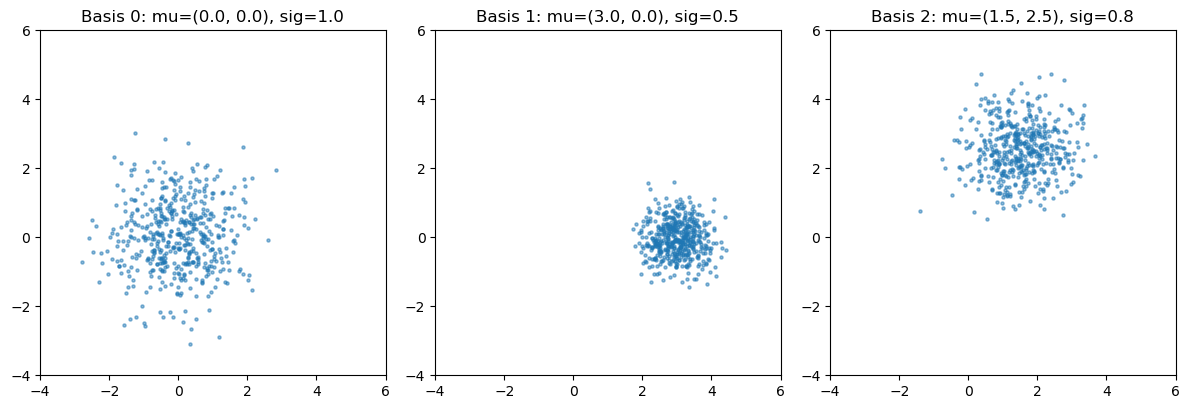

In [3]:
# basis points in parameter space: (mu_x, mu_y, scale)
basis_params = [
    (0.0, 0.0, 1.0),   # centered, unit scale
    (3.0, 0.0, 0.5),   # shifted right, tight
    (1.5, 2.5, 0.8),   # shifted up-right
]

def sample_basis(idx, n):
    """Sample from basis distribution idx."""
    mu_x, mu_y, scale = basis_params[idx]
    mu = torch.tensor([mu_x, mu_y])
    return mu + scale * torch.randn(n, 2)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, ax in enumerate(axes):
    data = sample_basis(i, 500).numpy()
    ax.scatter(data[:, 0], data[:, 1], s=5, alpha=0.5)
    ax.set_title(f"Basis {i}: mu=({basis_params[i][0]}, {basis_params[i][1]}), sig={basis_params[i][2]}")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## 2. Simple morphing model

Parametrize by a single parameter $ t \in [0, 1]$ with quadratic Bernstein basis:
- $f_{0}(t) = (1-t)^{2}$
- $f_{1}(t) = 2t(1-t)$ 
- $f_{2}(t) = t^{2}$

This gives Bézier-like interpolation [link](https://en.wikipedia.org/wiki/Bézier_curve). Weights are always positive and sum to 1.

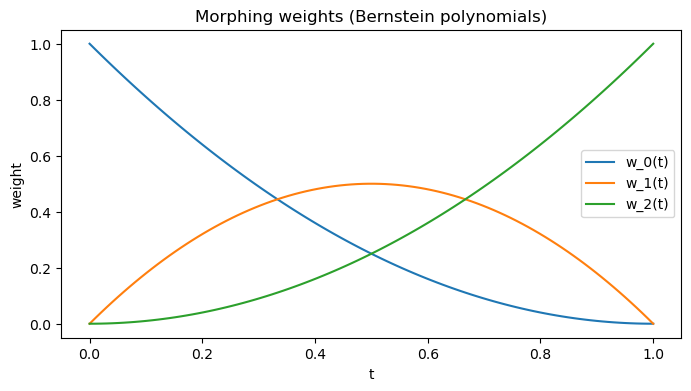

In [4]:
def morphing_weights(t):
    """Quadratic Bernstein basis"""
    t = torch.as_tensor(t, dtype=torch.float32)
    w0 = (1 - t) ** 2
    w1 = 2 * t * (1 - t)
    w2 = t ** 2
    return torch.stack([w0, w1, w2], dim=-1)

# weights vs t
ts = torch.linspace(0, 1, 100)
ws = morphing_weights(ts)
plt.figure(figsize=(8, 4))
for i in range(3):
    plt.plot(ts.numpy(), ws[:, i].numpy(), label=f"w_{i}(t)")
plt.xlabel("t")
plt.ylabel("weight")
plt.legend()
plt.title("Morphing weights (Bernstein polynomials)")
plt.show()

## 3. Train a flow for each basis distribution

In [5]:

def train_flow(basis_idx, n_data=10000, n_steps=2000):
    """Train a flow on basis distribution."""
    data = sample_basis(basis_idx, n_data)
    field = nami.VelocityField(dim=2)
    optimizer = torch.optim.Adam(field.parameters(), lr=1e-3)
    for step in range(n_steps):
        x_source = torch.randn_like(data)
        loss = nami.fm_loss(field, data, x_source)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    base = nami.StandardNormal(event_shape=(2,))
    solver = nami.RK4(steps=32)
    fm = nami.FlowMatching(field, base, solver, event_ndim=1)
    print(f"Basis {basis_idx}: final loss = {loss.item():.4f}")
    return fm

# train all 3 flows
flows = [train_flow(i) for i in range(3)]

Basis 0: final loss = 1.5816
Basis 1: final loss = 0.7786
Basis 2: final loss = 1.2506


### verify each flow learned its basis

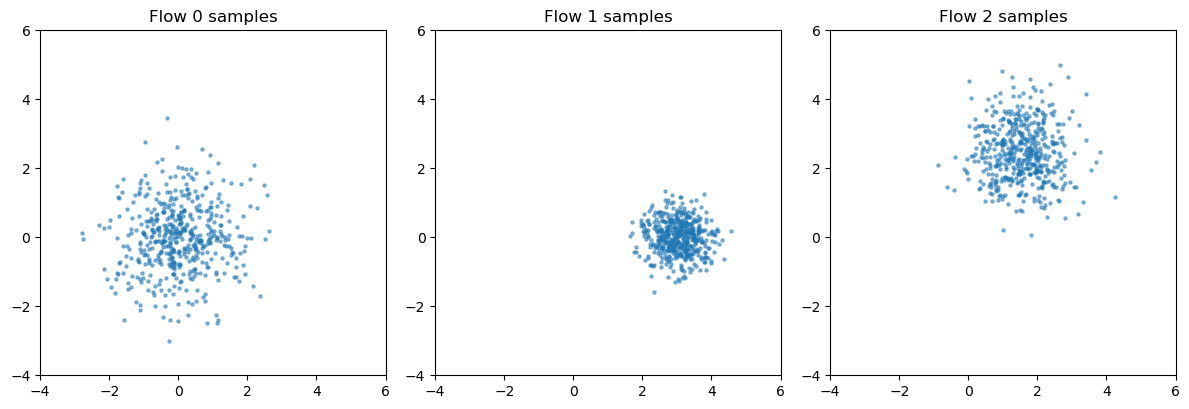

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, (ax, fm) in enumerate(zip(axes, flows)):
    samples = fm(None).sample((500,)).detach().numpy()
    ax.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
    ax.set_title(f"Flow {i} samples")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')
plt.tight_layout()
plt.show()

##  Morphed sampling at arbitrary t

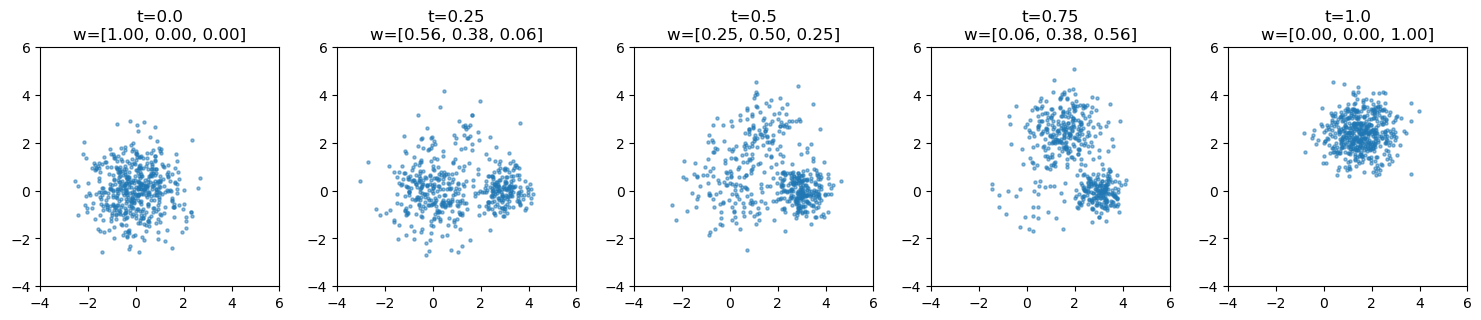

In [7]:
def morphed_sample(flows, t, n_samples):
    """Sample from morphed distribution at parameter t."""
    w = morphing_weights(t)
    
    # sample component indices according to weights
    k = torch.multinomial(w, n_samples, replacement=True)
    
    # collect samples from each component
    samples = []
    for i, fm in enumerate(flows):
        n_i = (k == i).sum().item()
        if n_i > 0:
            samples.append(fm(None).sample((n_i,)).detach())
    
    samples = torch.cat(samples)
    return samples[torch.randperm(len(samples))]


# show morphing at different t values
t_values = [0.0, 0.25, 0.5, 0.75, 1.0]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, t in zip(axes, t_values):
    samples = morphed_sample(flows, t, 500).numpy()
    ax.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
    w = morphing_weights(t)
    ax.set_title(f"t={t}\nw=[{w[0]:.2f}, {w[1]:.2f}, {w[2]:.2f}]")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')

plt.tight_layout()
plt.show()

## Morphed density evaluation

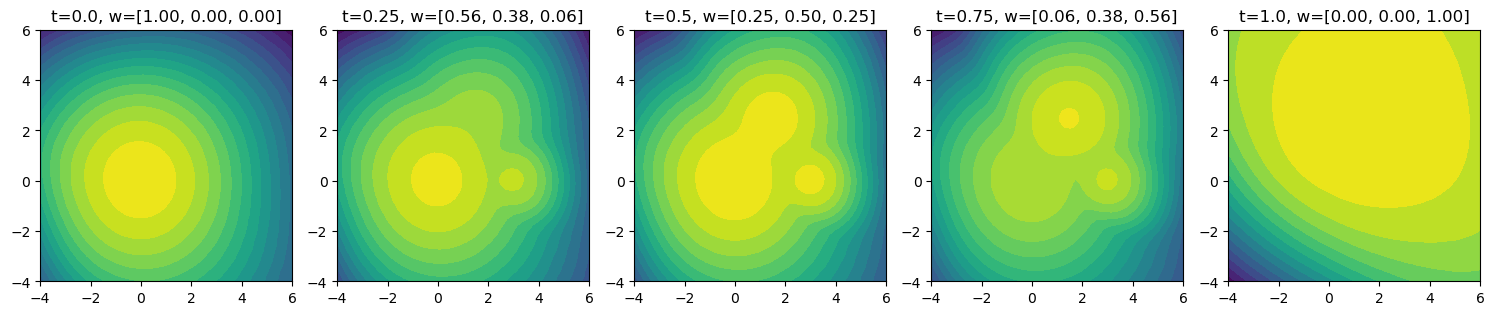

In [8]:
def morphed_log_prob(x, flows, t):
    """Evaluate log p(x) at morphed parameter t."""
    w = morphing_weights(t)
    estimator = nami.HutchinsonDivergence()
    
    # get log probs from each component
    log_probs = torch.stack([
        fm(None).log_prob(x, estimator=estimator) for fm in flows
    ])  # (3, *batch)
    
    # Mixture --->  p = sum_k w_k p_k
    # so log p = logsumexp(log w_k + log p_k)
    log_w = w.log().view(-1, *([1] * (log_probs.ndim - 1)))
    return torch.logsumexp(log_w + log_probs, dim=0)


def plot_density(flows, t, ax, resolution=50):
    """Plot density contours at parameter t."""
    x = torch.linspace(-4, 6, resolution)
    y = torch.linspace(-4, 6, resolution)
    xx, yy = torch.meshgrid(x, y, indexing='xy')
    grid = torch.stack([xx.flatten(), yy.flatten()], dim=-1)
    with torch.no_grad():
        logp = morphed_log_prob(grid, flows, t)
    
    logp = logp.reshape(resolution, resolution).numpy()
    ax.contourf(xx.numpy(), yy.numpy(), logp, levels=20, cmap='viridis')
    w = morphing_weights(t)
    ax.set_title(f"t={t}, w=[{w[0]:.2f}, {w[1]:.2f}, {w[2]:.2f}]")
    ax.set_aspect('equal')


fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for ax, t in zip(axes, t_values):
    plot_density(flows, t, ax)
plt.tight_layout()
plt.show()

## sweep through morphing parameter

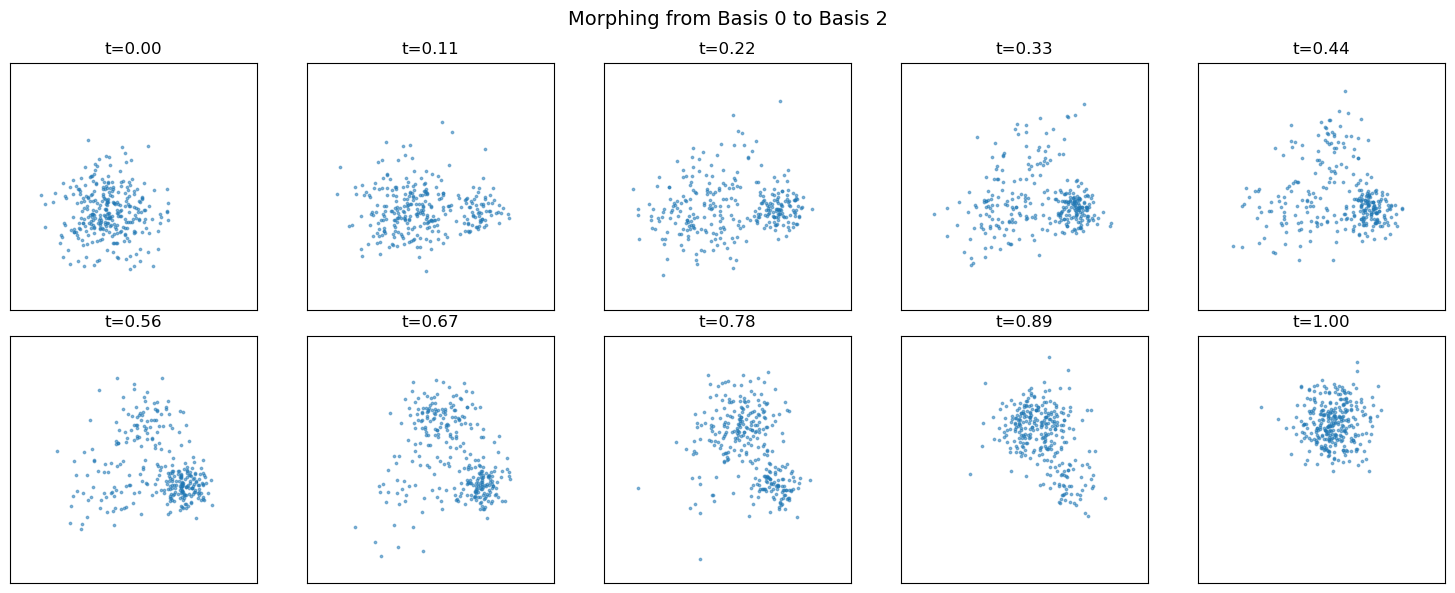

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
t_sweep = torch.linspace(0, 1, 10)

for ax, t in zip(axes.flat, t_sweep):
    samples = morphed_sample(flows, t.item(), 300).numpy()
    ax.scatter(samples[:, 0], samples[:, 1], s=3, alpha=0.5)
    ax.set_title(f"t={t:.2f}")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Morphing from Basis 0 to Basis 2", fontsize=14)
plt.tight_layout()
plt.show()


## Compare to analytical Gaussian mixture

Since our basis distributions are Gaussians, we can compute the exact morphed distribution analytically.

In [10]:
def analytical_sample(t, n_samples):
    """Sample from exact Gaussian mixture at parameter t."""
    w = morphing_weights(t)
    k = torch.multinomial(w, n_samples, replacement=True)
    samples = []
    for i, (mu_x, mu_y, scale) in enumerate(basis_params):
        n_i = (k == i).sum().item()
        if n_i > 0:
            mu = torch.tensor([mu_x, mu_y])
            samples.append(mu + scale * torch.randn(n_i, 2))
            
    samples = torch.cat(samples)
    return samples[torch.randperm(len(samples))]


def analytical_log_prob(x, t):
    """Exact log p(x) for Gaussian mixture at parameter t."""
    w = morphing_weights(t)
    
    log_probs = []
    for i, (mu_x, mu_y, scale) in enumerate(basis_params):
        mu = torch.tensor([mu_x, mu_y])
        # 2D isotropic Gaussian: log p = -0.5 * ||x-mu||^2/sigma^2 - log(2*pi*sigma^2)
        diff = x - mu
        log_p = -0.5 * (diff ** 2).sum(dim=-1) / (scale ** 2) - np.log(2 * np.pi * scale ** 2)
        log_probs.append(log_p)
    
    log_probs = torch.stack(log_probs)  # (3, *batch)
    log_w = w.log().view(-1, *([1] * (log_probs.ndim - 1)))
    return torch.logsumexp(log_w + log_probs, dim=0)

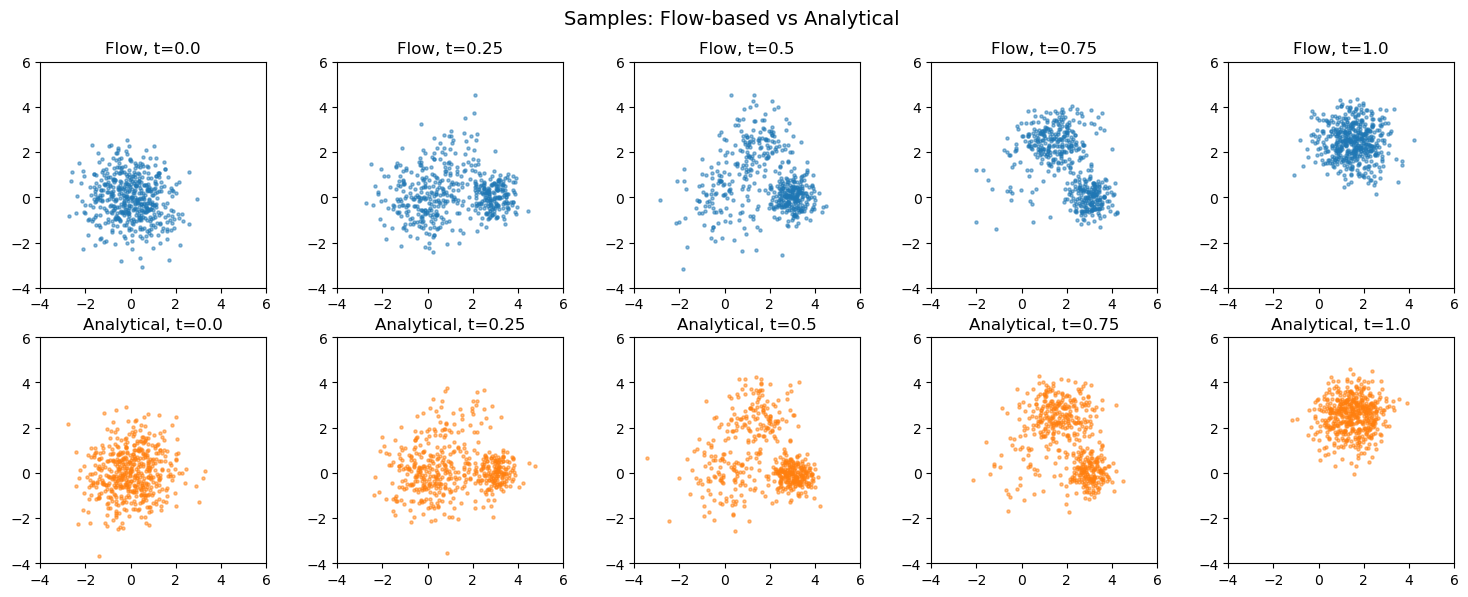

In [11]:
# flow vs analytical
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for col, t in enumerate(t_values):
    # flow samples (top row)
    ax_flow = axes[0, col]
    s_flow = morphed_sample(flows, t, 500).numpy()
    ax_flow.scatter(s_flow[:, 0], s_flow[:, 1], s=5, alpha=0.5, c='C0')
    ax_flow.set_title(f"Flow, t={t}")
    ax_flow.set_xlim(-4, 6)
    ax_flow.set_ylim(-4, 6)
    ax_flow.set_aspect('equal')
    
    # analytical samples (bottom row)
    ax_true = axes[1, col]
    s_true = analytical_sample(t, 500).numpy()
    ax_true.scatter(s_true[:, 0], s_true[:, 1], s=5, alpha=0.5, c='C1')
    ax_true.set_title(f"Analytical, t={t}")
    ax_true.set_xlim(-4, 6)
    ax_true.set_ylim(-4, 6)
    ax_true.set_aspect('equal')

plt.suptitle("Samples: Flow-based vs Analytical", fontsize=14)
plt.tight_layout()
plt.show()

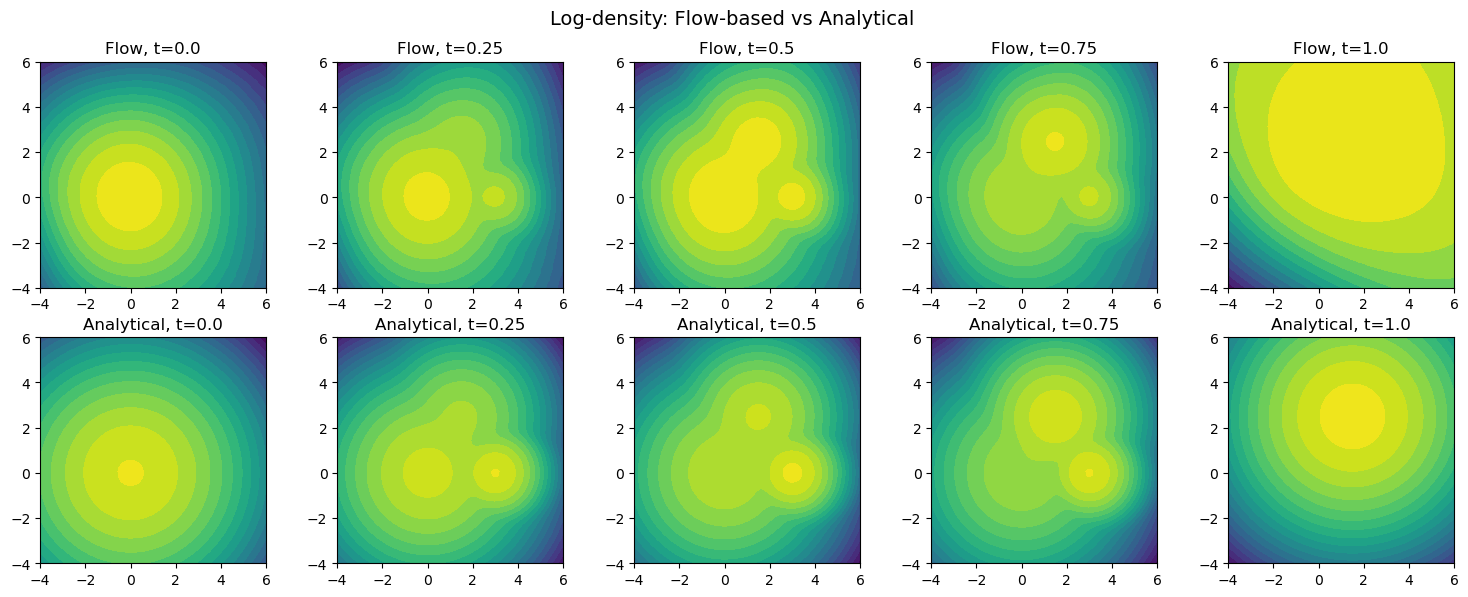

In [12]:
# compare density contours
resolution = 60
x = torch.linspace(-4, 6, resolution)
y = torch.linspace(-4, 6, resolution)
xx, yy = torch.meshgrid(x, y, indexing='xy')
grid = torch.stack([xx.flatten(), yy.flatten()], dim=-1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for col, t in enumerate(t_values):
    ax_flow = axes[0, col]
    with torch.no_grad():
        logp_flow = morphed_log_prob(grid, flows, t)
    logp_flow = logp_flow.reshape(resolution, resolution).numpy()
    ax_flow.contourf(xx.numpy(), yy.numpy(), logp_flow, levels=20, cmap='viridis')
    ax_flow.set_title(f"Flow, t={t}")
    ax_flow.set_aspect('equal')
    
    ax_true = axes[1, col]
    logp_true = analytical_log_prob(grid, t).reshape(resolution, resolution).numpy()
    ax_true.contourf(xx.numpy(), yy.numpy(), logp_true, levels=20, cmap='viridis')
    ax_true.set_title(f"Analytical, t={t}")
    ax_true.set_aspect('equal')

plt.suptitle("Log-density: Flow-based vs Analytical", fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
# MSE of log-prob on grid
print("MSE(log p_flow, log p_analytical) at each t:")
print("-" * 40)
for t in t_values:
    with torch.no_grad():
        logp_flow = morphed_log_prob(grid, flows, t)
    logp_true = analytical_log_prob(grid, t)
    
    # mask out very low density regions (where both are ~-inf)
    mask = logp_true > -20
    mse = ((logp_flow[mask] - logp_true[mask]) ** 2).mean().item()
    print(f"t={t:.2f}: MSE = {mse:.4f}")

MSE(log p_flow, log p_analytical) at each t:
----------------------------------------
t=0.00: MSE = 0.6654
t=0.25: MSE = 1.2286
t=0.50: MSE = 1.2685
t=0.75: MSE = 1.2822
t=1.00: MSE = 29.3668


so bad at boundary, weight loss for late times?

## Single conditional flow

Instead of 3 separate flows + mixture, train one flow conditioned on `t`. The network learns the morphing implicitly.

In [14]:
# use positional encoding for t_morph to make it more informative
class ConditionalVelocityField(nn.Module):
    def __init__(self, dim=2, cond_dim=1, hidden=128, n_freq=4):
        super().__init__()
        self.n_freq = n_freq
        # encode t_morph with sinusoidal features
        encoded_dim = 2 * n_freq  # sin/cos for each frequency
        
        self.net = nn.Sequential(
            nn.Linear(dim + 1 + encoded_dim, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
            nn.SiLU(),
            nn.Linear(hidden, dim),
        )

    @property
    def event_ndim(self):
        return 1

    def encode_condition(self, c):
        """Encode scalar condition with positional encoding."""
        # c: (..., 1)
        c = c.squeeze(-1)  # (...,)
        freqs = torch.arange(1, self.n_freq + 1, device=c.device, dtype=c.dtype)
        angles = c.unsqueeze(-1) * freqs * 2 * torch.pi  # (..., n_freq)
        encoded = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)  # (..., 2*n_freq)
        return encoded

    def forward(self, x, t, c):
        lead_shape = x.shape[:-1]
        
        if t.dim() == 0:
            t_exp = t.expand(*lead_shape).unsqueeze(-1)
        else:
            t_exp = t.unsqueeze(-1).expand(*lead_shape, 1)
    
        c_encoded = self.encode_condition(c)  # (..., 2*n_freq)
        
        inp = torch.cat([x, t_exp, c_encoded], dim=-1)
        return self.net(inp)

In [15]:
# ample (x, t_morph) pairs from the morphed distribution
cond_field = ConditionalVelocityField(
                dim=2,
                cond_dim=1,
                hidden=128,
                n_freq=8,
                )

optimizer = torch.optim.Adam(cond_field.parameters(), lr=1e-3)

n_steps = 10000
batch_size = 512

for step in range(n_steps):
    t_morph = torch.rand(batch_size)
    
    # for each t_morph, sample x from the corresponding mixture
    # (sample component k with prob w_k, then sample from that Gaussian)
    w = morphing_weights(t_morph)  # (batch, 3)
    k = torch.multinomial(w, 1).squeeze(-1)  # (batch,)
    
    # sample from selected basis Gaussians
    x_target = torch.zeros(batch_size, 2)
    for i, (mu_x, mu_y, scale) in enumerate(basis_params):
        mask = k == i
        n_i = mask.sum().item()
        if n_i > 0:
            mu = torch.tensor([mu_x, mu_y])
            x_target[mask] = mu + scale * torch.randn(n_i, 2)
    
    # standard flow matching training with condition
    x_source = torch.randn_like(x_target)
    c = t_morph.unsqueeze(-1)  # (batch, 1)
    
    loss = nami.fm_loss(cond_field, x_target, x_source, c=c)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 1000 == 0:
        print(f"Step {step}: loss = {loss.item():.4f}")

print(f"Final loss: {loss.item():.4f}")

Step 0: loss = 4.7810
Step 1000: loss = 2.0712
Step 2000: loss = 1.9316
Step 3000: loss = 1.7776
Step 4000: loss = 1.8576
Step 5000: loss = 1.7874
Step 6000: loss = 1.9675
Step 7000: loss = 1.8974
Step 8000: loss = 1.9011
Step 9000: loss = 1.9868
Final loss: 1.9760


In [16]:
# BoundField: stores conditioning, creates tensor matching x's leading dims
class BoundField(nn.Module):
    def __init__(self, field, c):
        super().__init__()
        self._field = field
        self._c_value = float(c.view(-1)[0].item())

    @property
    def event_ndim(self):
        return self._field.event_ndim

    def forward(self, x, t, c=None):
        # Create c matching x's leading dims: x=(sample, batch, event) -> c=(sample, batch, 1)
        lead_shape = x.shape[:-1]
        c_new = torch.full((*lead_shape, 1), self._c_value, device=x.device, dtype=x.dtype)
        return self._field(x, t, c_new)


In [ ]:
# create a LazyField wrapper that binds conditioning
class ConditionedLazyField(nami.LazyField):
    def __init__(self, field):
        super().__init__()
        self._field = field
    
    @property
    def event_ndim(self):
        return self._field.event_ndim
    
    def forward(self, c):
        """Return a bound field that has c baked in."""
        return BoundField(self._field, c)

# create conditional FlowMatching
base = nami.StandardNormal(event_shape=(2,))
solver = nami.RK4(steps=32)

cond_fm = nami.FlowMatching(
    ConditionedLazyField(cond_field),
    base, 
    solver, 
    event_ndim=1
)

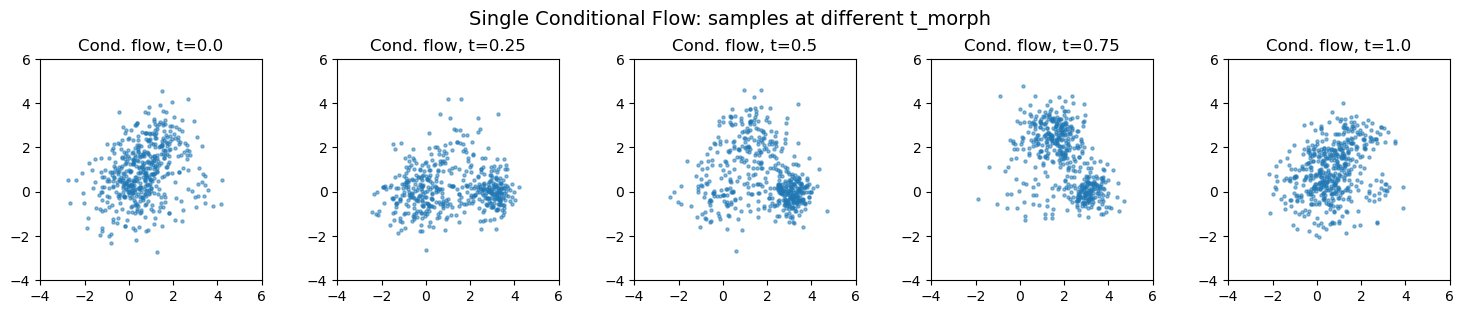

In [18]:
# Sample from conditional flow at different t_morph values
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for ax, t in zip(axes, t_values):
    # Condition tensor: shape (1, 1) for single t_morph value
    c = torch.tensor([[t]])
    
    # Sample via conditioned flow - this gives (500, 1, 2)
    samples = cond_fm(c).sample((500,)).detach().numpy()
    
    # Squeeze the batch dimension: (500, 1, 2) -> (500, 2)
    samples = samples.squeeze(1)
    
    ax.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5)
    ax.set_title(f"Cond. flow, t={t}")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')

plt.suptitle("Single Conditional Flow: samples at different t_morph", fontsize=14)
plt.tight_layout()
plt.show()

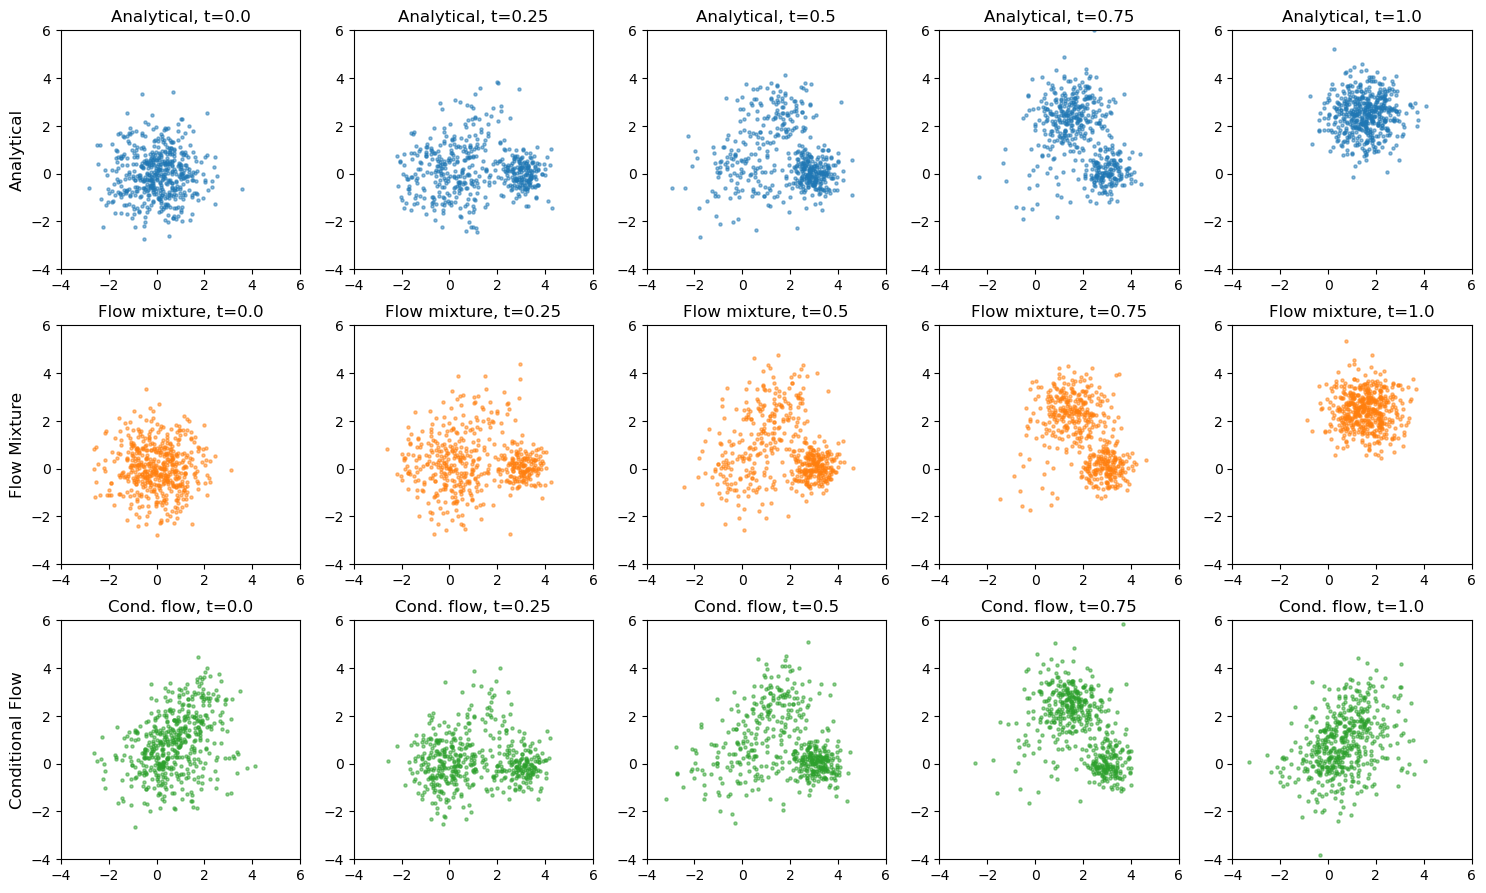

In [19]:
# compare all 3 approaches: Analytical vs Flow Mixture vs Conditional Flow
fig, axes = plt.subplots(3, 5, figsize=(15, 9))

for col, t in enumerate(t_values):
    # Row 0: Ana
    ax = axes[0, col]
    s = analytical_sample(t, 500).numpy()
    ax.scatter(s[:, 0], s[:, 1], s=5, alpha=0.5, c='C0')
    ax.set_title(f"Analytical, t={t}")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')
    
    # Row 1: Flow mixture
    ax = axes[1, col]
    s = morphed_sample(flows, t, 500).numpy()
    ax.scatter(s[:, 0], s[:, 1], s=5, alpha=0.5, c='C1')
    ax.set_title(f"Flow mixture, t={t}")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')
    
    # Row 2: Conditional flow
    ax = axes[2, col]
    c = torch.tensor([[t]])
    s = cond_fm(c).sample((500,)).detach().numpy()
    s = s.squeeze(1)
    ax.scatter(s[:, 0], s[:, 1], s=5, alpha=0.5, c='C2')
    ax.set_title(f"Cond. flow, t={t}")
    ax.set_xlim(-4, 6)
    ax.set_ylim(-4, 6)
    ax.set_aspect('equal')

axes[0, 0].set_ylabel("Analytical", fontsize=12)
axes[1, 0].set_ylabel("Flow Mixture", fontsize=12)
axes[2, 0].set_ylabel("Conditional Flow", fontsize=12)
plt.tight_layout()
plt.show()

In [20]:
# auantitative: MSE comparison for conditional flow
def cond_flow_log_prob(x, t_morph):
    """Log prob from conditional flow at t_morph."""
    c = torch.full((x.shape[0], 1), t_morph)
    estimator = nami.HutchinsonDivergence()
    return cond_fm(c[:1]).log_prob(x, estimator=estimator)

print("MSE comparison: Flow Mixture vs Conditional Flow")
print(f"{'t':<6} {'Mixture MSE':<15} {'Cond. Flow MSE':<15}")
print("-" * 50)

for t in t_values:
    logp_true = analytical_log_prob(grid, t)
    mask = logp_true > -20
    
    with torch.no_grad():
        logp_mix = morphed_log_prob(grid, flows, t)
    mse_mix = ((logp_mix[mask] - logp_true[mask]) ** 2).mean().item()
    
    with torch.no_grad():
        logp_cond = cond_flow_log_prob(grid, t)
    mse_cond = ((logp_cond[mask] - logp_true[mask]) ** 2).mean().item()
    
    print(f"{t:<6.2f} {mse_mix:<15.4f} {mse_cond:<15.4f}")

MSE comparison: Flow Mixture vs Conditional Flow
t      Mixture MSE     Cond. Flow MSE 
--------------------------------------------------
0.00   0.6654          16.0255        
0.25   1.2288          3.4486         
0.50   1.2680          3.7996         
0.75   1.2811          3.2058         
1.00   29.3404         33.5013        


### flow Mixture vs Conditional Flow

The conditional flow learns the **entire family** of distributions p(x|t) in one model, enabling Gradient-based inference ($\partial \log p / \partial t$), smooth interpolation between any parameter values, but condiioning needs to be right.

In [21]:
# check variance of flow 2's log_prob
logps = []
for _ in range(10):
    with torch.no_grad():
        logps.append(flows[2](None).log_prob(grid, estimator=nami.HutchinsonDivergence()))
logps = torch.stack(logps)
print(f"Std of log_prob estimates: {logps.std(dim=0).mean():.4f}")

Std of log_prob estimates: 0.0401


In [22]:
# direct comparison for basis 2 only
logp_flow2 = flows[2](None).log_prob(grid, estimator=nami.HutchinsonDivergence())
mu = torch.tensor([1.5, 2.5])
scale = 0.8
logp_true2 = -0.5 * ((grid - mu) ** 2).sum(-1) / scale**2 - np.log(2 * np.pi * scale**2)

mask = logp_true2 > -20
print(f"Flow 2 MSE: {((logp_flow2[mask] - logp_true2[mask])**2).mean():.4f}")

Flow 2 MSE: 29.3466
